In [1]:
import numpy as np
import os
import librosa
import librosa.display
from matplotlib import pyplot as plt
import IPython.display as ipd
from skimage.feature import peak_local_max
from scipy import ndimage, misc
import datetime

## Constants

In [2]:
DB_FOLDER = "./database_recordings"
Q_FOLDER = "./query_recordings"
OUTPUT_PATH = "output.txt"

In [3]:
WINDOW_SIZE = 1024
HOP_SIZE = 256
SR = 22050
NUM_RANK = 3
NEIGH_WIDTH_F = 30
NEIGH_WIDTH_T = 20
TAR_WIDTH_F = 50
TAR_WIDTH_T = 70

## Functions

In [4]:
def getStft(data, sr, window, hop):
    return np.abs(librosa.stft(data,n_fft=window,window='hann',win_length=window,hop_length=hop))

def plotStft(D, sr):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max),y_axis='linear', x_axis='time',sr=sr)
    
def getMel(data,sr, window, hop, n_mels=128,fmax=8000):
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels,fmax=fmax, win_length=window,hop_length=hop)
    return S

def plotMel(S,sr,fmax=8000):
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fmax)
    
def getCQ(data, sr):
    C = np.abs(librosa.cqt(data, sr=sr))
    return C

def plotCQ(C, sr):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')

In [5]:
def getConstellation(spectrogram, width_freq, width_time):
    maxed_filter = ndimage.maximum_filter(spectrogram, size=(width_freq,width_time))
    peaks = (maxed_filter == spectrogram) #find locations of maximum in original spectrogram
    coordinates = np.where(peaks) #get coordinates of peaks
    
    return coordinates

def getConstellationBool(spectrogram, width_freq, width_time):
    maxed_filter = ndimage.maximum_filter(spectrogram, size=(width_freq,width_time))
    peaks = (maxed_filter == spectrogram)
    return peaks

def plotConstellation(coordinates):
    freq_axis = coordinates[0]
    time_axis = coordinates[1]
    plt.figure(figsize=(10, 5))
    plt.scatter(time_axis,freq_axis, s=5)

In [6]:
def dbToInvIdx(constellation):
    tf_pts = zip(constellation[1], constellation[0])
    inv_doc = {}
    for t,f in tf_pts:
        if f in inv_doc:
            inv_doc[f].append(t)
        else:
            inv_doc[f] = [t]
            
    return inv_doc

def dbToPairIdx(const_bool):
    coordinates = np.where(const_bool)
    tf_pts = zip(coordinates[1], coordinates[0])
    sorted_pts = sorted(tf_pts)
    hashes = {}
    for t,f in sorted_pts:
        target_zone = const_bool[f:(f+TAR_WIDTH_F),(t + 1):(t+TAR_WIDTH_T + 1)]
        neighbors = np.where(target_zone)
        neighbors = zip(neighbors[1] + t + 1, neighbors[0] + f)
        for neigh_t, neigh_f in neighbors:
            hash_val = (f, neigh_f, (neigh_t - t))
            if hash_val in hashes:
                hashes[hash_val].append(t)
            else:
                hashes[hash_val] = [t]
    return hashes

def qToPairs(const_q):
    coordinates = np.where(const_q)
    tf_pts = zip(coordinates[1], coordinates[0])
    sorted_pts = sorted(tf_pts)
    queries = []
    for t,f in sorted_pts:
        target_zone = const_q[f:(f+TAR_WIDTH_F),(t + 1):(t+TAR_WIDTH_T + 1)]
        neighbors = np.where(target_zone)
        neighbors = zip(neighbors[1] + t + 1, neighbors[0] + f)
        for neigh_t, neigh_f in neighbors:
            queries.append((t,(f, neigh_f, (neigh_t - t))))
    return queries

def matchConstellations(d_inv, q_constellation, d_len, q_len):
    min_shift = -1 * q_len
    max_shift = d_len + q_len
    shift_rng = max_shift - min_shift

    query_pts = zip(q_constellation[1], q_constellation[0])
    num_Q = len(q_constellation[0])

    indicators = np.zeros((num_Q, shift_rng))
    for i, (t,f) in enumerate(query_pts):
        inv_idx = []
        if f in d_inv:
            inv_idx = d_inv[f].copy()
        inv_idx = inv_idx - t + q_len
        for idx in inv_idx:
            indicators[i][idx] = 1
            
    matching = np.sum(indicators, axis=0)
    max_idx = np.argmax(matching)
    max_val = matching[max_idx]
    max_shift = max_idx - q_len
    
    return max_shift, max_val, matching

def matchConstellationsPairwise(d_inv, queries, d_len, q_len):
    min_shift = -1 * q_len
    max_shift = d_len + q_len
    shift_rng = max_shift - min_shift

    num_Q = len(queries)
    indicators = np.zeros((num_Q, shift_rng))
    for i,(t,hash_val) in enumerate(queries):
        inv_idx = []
        if hash_val in d_inv:
            inv_idx = d_inv[hash_val].copy()
        inv_idx = inv_idx - t + q_len
        for idx in inv_idx:
            indicators[i][idx] = 1
            
    matching = np.sum(indicators, axis=0)
    max_idx = np.argmax(matching)
    max_val = matching[max_idx]
    max_shift = max_idx - q_len
    
    return max_shift, max_val, matching

## Test on single query/db pair

In [7]:
TEST_DB = os.path.join(DB_FOLDER, "pop.00025.wav")
TEST_Q = os.path.join(Q_FOLDER, "pop.00025-snippet-10-10.wav")

In [8]:
y, sr = librosa.load(TEST_DB, sr=SR)
print(y.shape, sr)
ipd.Audio(y, rate=SR)

(661504,) 22050


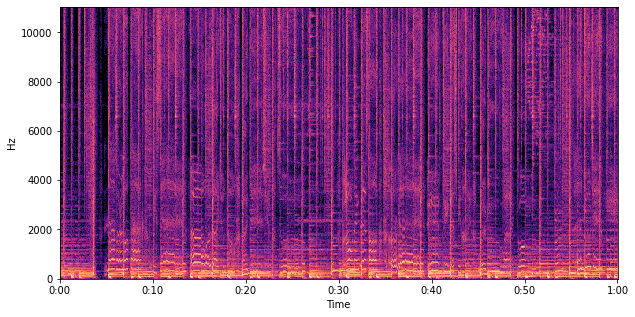

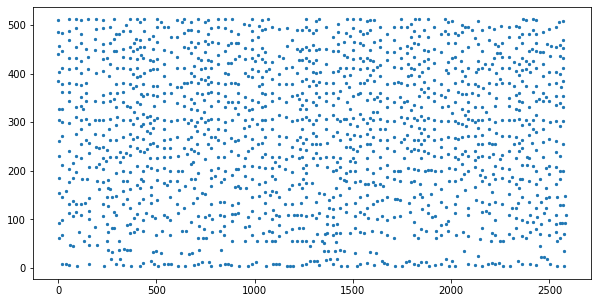

In [9]:
D_spec = getStft(y, SR, WINDOW_SIZE, HOP_SIZE)
plotStft(D_spec, SR)

D_const = getConstellation(np.log(D_spec + 1e-7), NEIGH_WIDTH_F,NEIGH_WIDTH_T)
plotConstellation(D_const)

In [10]:
y, sr = librosa.load(TEST_Q, sr=SR)
print(y.shape, sr)
ipd.Audio(y, rate=SR)

(221184,) 22050


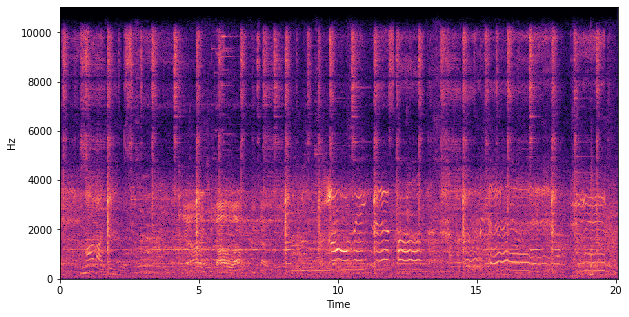

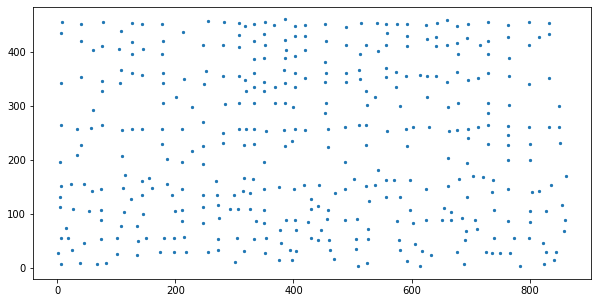

In [11]:
Q_spec = getStft(y, SR, WINDOW_SIZE, HOP_SIZE)
plotStft(Q_spec, SR)

Q_const = getConstellation(np.log(Q_spec + 1e-7), NEIGH_WIDTH_F,NEIGH_WIDTH_T)
plotConstellation(Q_const)

910 118.0


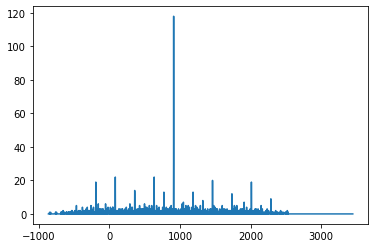

In [12]:
db_len = D_spec.shape[1]
q_len = Q_spec.shape[1]

inverted_idx = dbToInvIdx(D_const)
shift, val, matching = matchConstellations(inverted_idx, Q_const, db_len, q_len)
print(shift, val)
plt.plot(range(-q_len,q_len + db_len), matching)

## Test Pairwise Indexing

910 134.0


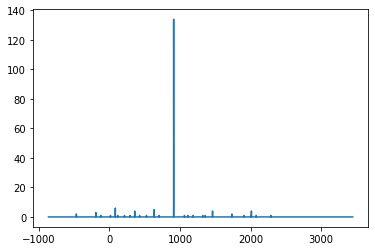

In [13]:
D_const = getConstellationBool(np.log(D_spec + 1e-7), NEIGH_WIDTH_F,NEIGH_WIDTH_T)
Q_const = getConstellationBool(np.log(Q_spec + 1e-7), NEIGH_WIDTH_F,NEIGH_WIDTH_T)

D_hashes = dbToPairIdx(D_const)
queries = qToPairs(Q_const)
shift, val, matching = matchConstellationsPairwise(D_hashes, queries, db_len, q_len)
print(shift, val)
plt.plot(range(-q_len,q_len + db_len), matching)

## Converting Files to Constellations

In [14]:
def fingerprintFromFile(filename, stft_type='stft'):
    y, sr = librosa.load(filename, sr=SR)
    if(stft_type == 'stft'):
        spec = getStft(y, SR, WINDOW_SIZE, HOP_SIZE)
    elif(stft_type == 'mel'):
        spec = getMel(y, SR, WINDOW_SIZE, HOP_SIZE)
    elif(stft_type == 'cq'):
        spec = getCQ(y, SR)
    const = getConstellation(np.log(spec + 1e-7), NEIGH_WIDTH_F,NEIGH_WIDTH_T)
    
    return const, spec.shape[1]

In [15]:
def fingerprintBuilder(fp_folder, stft_type='stft'):
    db_fingerprints = {}
    for file in os.listdir(fp_folder):
        full_path = os.path.join(fp_folder,file)
        constellation, frames = fingerprintFromFile(full_path, stft_type=stft_type)
        inv_idx = dbToInvIdx(constellation)
        db_fingerprints[file] = inv_idx, frames
    
    return db_fingerprints

In [16]:
def fingerprintFromFilePairwise(filename, stft_type='stft'):
    y, sr = librosa.load(filename, sr=SR)
    if(stft_type == 'stft'):
        spec = getStft(y, SR, WINDOW_SIZE, HOP_SIZE)
    elif(stft_type == 'mel'):
        spec = getMel(y, SR, WINDOW_SIZE, HOP_SIZE)
    elif(stft_type == 'cq'):
        spec = getCQ(y, SR)
    const = getConstellationBool(np.log(spec + 1e-7), NEIGH_WIDTH_F,NEIGH_WIDTH_T)
    
    return const, spec.shape[1]

def fingerprintBuilderPairwise(fp_folder, stft_type='stft'):
    db_fingerprints = {}
    for file in os.listdir(fp_folder):
        full_path = os.path.join(fp_folder,file)
        constellation, frames = fingerprintFromFilePairwise(full_path, stft_type=stft_type)
        inv_idx = dbToPairIdx(constellation)
        db_fingerprints[file] = inv_idx, frames
    
    return db_fingerprints

## Run System

In [17]:
def audioIdentification(q_folder, fingerprints, output_path, stft_type='stft'):
    f = open(output_path, "w")
    for file in os.listdir(q_folder):
        full_path = os.path.join(q_folder, file)
        q_fp, q_len = fingerprintFromFile(full_path,stft_type=stft_type)
        
        matches = []
        for name, (inv_idx, d_len) in fingerprints.items():
            shift, max_val, _ = matchConstellations(inv_idx, q_fp, d_len, q_len)
            matches.append((name, shift, max_val))
        
        matches.sort(key=lambda tup: tup[2], reverse=True) #sort by maximum match score
        top_matches = [m[0] for m in matches[0:NUM_RANK]]
        f.write("{}\t{}\t{}\t{}\n".format(file, top_matches[0], top_matches[1], top_matches[2]))
    
    f.close()

In [18]:
#fingerprints = fingerprintBuilder(DB_FOLDER)
#audioIdentification(Q_FOLDER, fingerprints, OUTPUT_PATH)

In [ ]:
def audioIdentificationPairwise(q_folder, fingerprints, output_path, stft_type='stft'):
    f = open(output_path, "w")
    for file in os.listdir(q_folder):
        full_path = os.path.join(q_folder, file)
        q_fp, q_len = fingerprintFromFilePairwise(full_path,stft_type=stft_type)
        queries = qToPairs(q_fp)
        matches = []
        for name, (inv_idx, d_len) in fingerprints.items():
            shift, max_val, _ = matchConstellationsPairwise(inv_idx, queries, d_len, q_len)
            matches.append((name, shift, max_val))
        
        matches.sort(key=lambda tup: tup[2], reverse=True) #sort by maximum match score
        top_matches = [m[0] for m in matches[0:NUM_RANK]]
        f.write("{}\t{}\t{}\t{}\n".format(file, top_matches[0], top_matches[1], top_matches[2]))
    f.close()

In [ ]:
fingerprints = fingerprintBuilderPairwise(DB_FOLDER)
audioIdentificationPairwise(Q_FOLDER, fingerprints, OUTPUT_PATH)

## Calculate Stats

In [21]:
def calcPrecisionRecall(query_string):
    split_string = query_string.split('\t')
    query_f = split_string[0]
    matches = [os.path.splitext(s)[0] for s in split_string[1::]]
    
    precision = [0.0,0.0,0.0]
    recall = [0.0,0.0,0.0]
    total_hits = 0
    for i in range(NUM_RANK):
        if matches[i] in query_f:
            total_hits += 1
        precision[i] = total_hits * 1.0 / (i + 1)
        recall[i] = total_hits
        
    return precision, recall

def calcAvgPrecision(OUTPUT_PATH):
    f = open(OUTPUT_PATH, "r")
    output_data = f.readlines()
    f.close()
    
    total_queries = len(output_data)
    sum_precision = 0.0
    for line in output_data:
        p, r = calcPrecisionRecall(line)
        sum_precision += np.max(p)
        
    return sum_precision / total_queries

In [22]:
avg_p = calcAvgPrecision(OUTPUT_PATH)
print("Average precision: {}".format(avg_p))

Average precision: 0.8137715179968702
